Emotion-Recognition Kaggle Model V11

## Transfer Learning MobileNet

VGG16 was very complex and heavy. I will try to experiment with MobileNet, then compare all the models I creted on the Keras dataset and decide which is better.

In [1]:
# Imports
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout, Input
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
import random
import glob
import itertools
import os
import shutil
import seedir as sd
import matplotlib.pyplot as plt
import plotly.graph_objects as pgo
import warnings
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
# Classses Distribution
print("Dataset Classes Distribution")

# Path to dataset
dataset_path = '../datasets/kaggle_dataset_train/'

# Let's display and count the files in the Kaggle training dataset
sd.seedir(dataset_path, style='emoji', itemlimit=10, depthlimit=1, beyond='content')

# Find number of images for each class
classes = []
values = []
for emotion in os.listdir(dataset_path):
    classes.append(emotion)
    values.append(len(os.listdir(dataset_path+emotion)))

# Chart visualization of the classes
fig = pgo.Figure(data=[pgo.Pie(labels=classes, values=values, hole=.4)])
fig.show()

Dataset Classes Distribution
📁 /
├─📁 angry/
│ └─0 folder(s), 3595 file(s)
├─📁 disgust/
│ └─0 folder(s), 393 file(s)
├─📁 fear/
│ └─0 folder(s), 3688 file(s)
├─📁 happy/
│ └─0 folder(s), 6493 file(s)
├─📁 neutral/
│ └─0 folder(s), 4469 file(s)
├─📁 sad/
│ └─0 folder(s), 4347 file(s)
└─📁 surprise/
  └─0 folder(s), 2854 file(s)


In [3]:
# Process the data
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Define sets
# Since the tesing set has more data than the created validate, we will use test as validate and validate as test
training_path = '../datasets/kaggle_dataset_train/'
valididation_path = '../datasets/kaggle_dataset_test/'
testing_path = '../datasets/kaggle_dataset_validate/'

Num GPUs Available:  1


Now we have to preprocess the images for MobileNet. To do this we use `tf.keras.applications.mobilenet.preprocess_input`.

“The only pre-processing we do is subtracting the mean RGB value,
computed on the training set, from each pixel.”

Still we have to convert the 1 channel image into 3 channels and then do the preprocess.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
This is the grayscale image after it was converted to color [[[162.9837 162.9837 162.9837]
  [127.9872 127.9872 127.9872]
  [113.9886 113.9886 113.9886]
  ...
  [138.9861 138.9861 138.9861]
  [140.9859 140.9859 140.9859]
  [133.9866 133.9866 133.9866]]

 [[146.9853 146.9853 146.9853]
  [113.9886 113.9886 113.9886]
  [101.9898 101.9898 101.9898]
  ...
  [141.9858 141.9858 141.9858]
  [137.9862 137.9862 137.9862]
  [137.9862 137.9862 137.9862]]

 [[111.9888 111.9888 111.9888]
  [105.9894 105.9894 105.9894]
  [ 91.9908  91.9908  91.9908]
  ...
  [139.986  139.986  139.986 ]
  [140.9859 140.9859 140.9859]
  [133.9866 133.9866 133.9866]]

 ...

 [[138.9861 138.9861 138.9861]
  [140.9859 140.9859 140.9859]
  [135.9864 135.9864 135.9864]
  ...
  [153.9846 153.9846 153.9846]
  [170.9829 170.9829 170.9829]
  [190.9809 190.9809 190.9809]]

 [[139.986  139.986  139.986 ]
  [132.9867 132.9

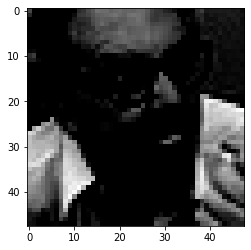

In [6]:
# The images I have in the Kaggle dataset are in grayscale, for MobileNet I have to convert them to RGB with three channels, what we do is just exand the channel we already have to 3 channels

def mobileNet_processed(img):
    # I first "convert" the image to RGB, by repeating the grayscale data x3 along the channel axis
    x=np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
    mychannel=np.repeat(x[:, :, np.newaxis], 3, axis=2)
    # Then I use the tf MobileNet preprocessing, which scales the pixel values in the image between -1 and 1, this function will return the preprocessed image data as a numpy array
    processedimage = tf.keras.applications.mobilenet.preprocess_input(mychannel)
    return processedimage

# I create the same function again but it won't return nothing, it will inded diplay the processed image
def mobileNet_processed_display(img):
   x=np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
   mychannel=np.repeat(x[:, :, np.newaxis], 3, axis=2)
   print("This is the grayscale image after it was converted to color",mychannel)
   processedimage = tf.keras.applications.mobilenet.preprocess_input(mychannel)
   print("This is the color image after mobileNet preprocess",processedimage)
   img = processedimage.astype(np.uint8)  # convert back to uint8
   plt.imshow(processedimage)
   plt.show()

# Here's an example with a grayscale image
gray = cv2.imread("../datasets/kaggle_dataset_train/angry/Training_3908.jpg")
mobileNet_processed_display(gray)

As we can see from the result above, the MobileNet preprocessing was correctly done, the results are all in the range 1 and -1.


In [7]:
# Now we use Keras's ImageDataGenerator class to create batches of data from the training, validation and testing sets
"""
for the preocessing_function I pass the function I created myself above, since we cannot use the normal tf function provided for vgg16 since we had first to expand the grayscale channel
I also remove color_mode since it was set to grayscale, and change target size to 224,224 since it was the original input shape of the VGG16 model
"""
train_batches = ImageDataGenerator(preprocessing_function=mobileNet_processed).flow_from_directory(directory=training_path, target_size=(224,224), classes=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], batch_size=32)
valid_batches = ImageDataGenerator(preprocessing_function=mobileNet_processed).flow_from_directory(directory=valididation_path, target_size=(224,224), classes=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], batch_size=32)
test_batches = ImageDataGenerator(preprocessing_function=mobileNet_processed).flow_from_directory(directory=testing_path, target_size=(224,224), classes=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], batch_size=32, shuffle=False)

Found 25839 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 2867 images belonging to 7 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

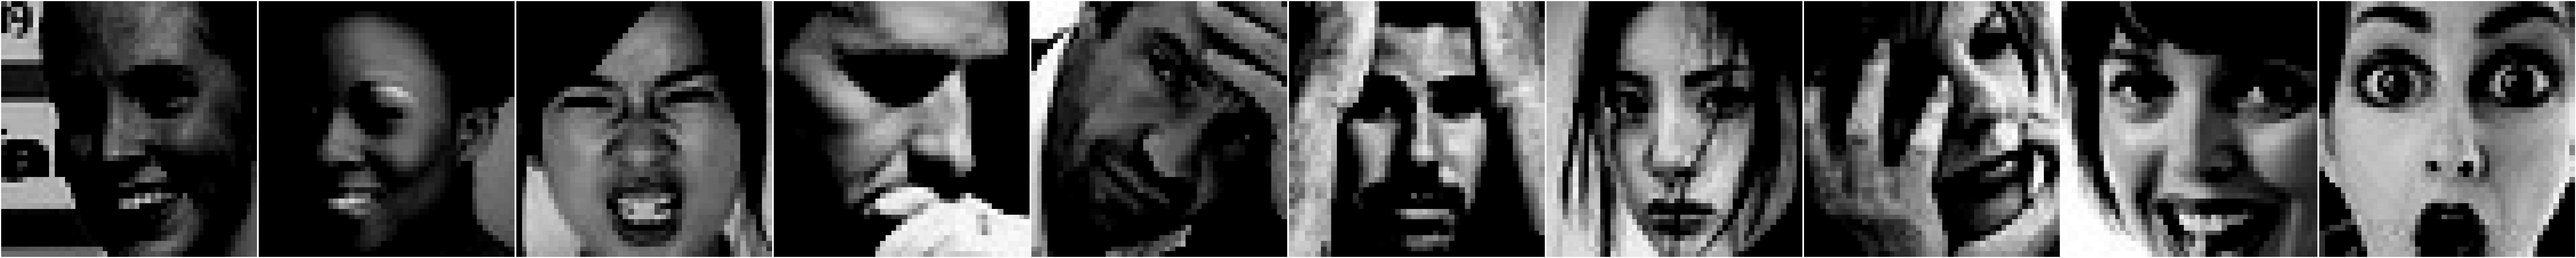

[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]


In [8]:
imgs, labels = next(train_batches)

# Plotting function obtained from TensorFlow's documentation to plot the processed images within our Jupyter notebook.
# The classes are represented with the one-hot encoding , for example 'angry' is [1. 0. 0. 0. 0. 0. 0.]

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(224,224))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)
print(labels)

In [9]:
# I download the MobileNet model
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

As we can see MobileNet is very complex, it has way more layers than VGG16 but VGG16 was more heavy and complex sinc it had a total of 138,357,544 parameters, while MobileNet has only 4,253,864 parameters.

Notice that the last Dense layer of MobileNet has 1000 outputs. These outputs correspond to the 1000 categories in the ImageNet library. We just have 7, but we have to cut more than just the last dense layer, and there is no optimal number or last layers to remove, so we have to experiment.

In [12]:
# I grab the output from the sixth to last layer of the model and store it in this variable x

x = mobile.layers[-6].output

In [13]:
# Here I set the output layers by adding all the MobileNet layers we saved on x, and add a dense output layer having 7 nodes
output = Dense(units=7, activation='softmax')(x)

# Now, we construct the new fine-tuned model, which we're calling model.

model = Model(inputs=mobile.input, outputs=output)

I want to keep some of the initial layers as they are so I set all the layers up to the 23th from the last layer to be non trainable.

In [14]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [16]:
# Now that the model is built, we compile the model using the Adam optimizer with a learning rate of 0.0001, a loss of categorical_cross_entropy, and we'll look at accuracy as our performance metric.

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

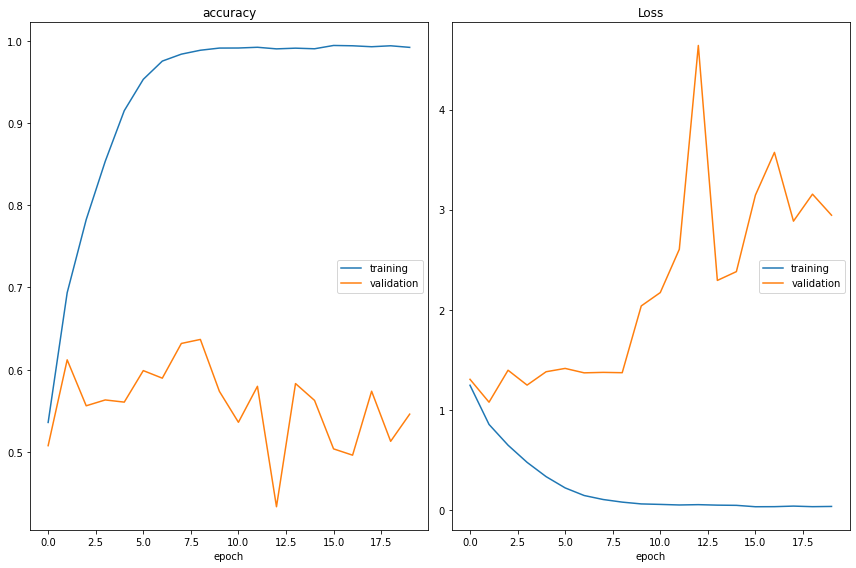

accuracy
	training         	 (min:    0.536, max:    0.994, cur:    0.992)
	validation       	 (min:    0.433, max:    0.637, cur:    0.546)
Loss
	training         	 (min:    0.034, max:    1.247, cur:    0.037)
	validation       	 (min:    1.078, max:    4.640, cur:    2.945)


In [17]:
# I plot the results in real life
callbacks = [PlotLossesKerasTF()]

# Now I will train the model using, I all make it run for 20 epochs this time
model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=20,
    callbacks=callbacks
)

By applying transfer learning on MobileNet we got a 99% accuracy on training which is very impressive. The accuracy on validation is only 54% with a max of 63%, so we still have overfitting. Since I tried created so many models, with different hyperparameters values I conclude that the main problem is that the dataset is not good and big enough. In fact many times I saw pictures in the dataset that were completly black or had no faces on them. So yes there is a degree of invalid images in the dataset.

Confusion matrix, without normalization
[[183   5 129   9  64   3   6]
 [ 10  15  14   0   3   1   0]
 [ 22   1 297   8  58   3  20]
 [ 19   0  95 474 114   2  17]
 [ 19   0 101  18 354   2   2]
 [ 37   1 236   5 162  38   4]
 [ 13   0  84   7  18   0 194]]


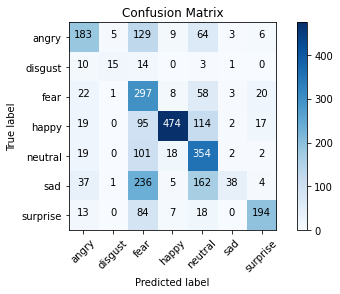

In [19]:
#Plotting Predictions With A Confusion Matrix
# To get a better visualization of these results, we'll plot them in a confusion matrix

test_imgs, test_labels = next(test_batches)
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_plot_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

This version performed good but still v6 which I created from scrathc without using transfer learning is the best with v3.

In [20]:
# I will save anyways the model for the archive (I specify the name this time)
model.save("kaggle_model_v11.h5")